---
# Previsão do Preço dos Aluguéis em Cidades Brasileiras
---

![title](./img/sp.jpg)

---

## *Objetivo:* Prever o preço dos aluguéis utilizando apenas as informações dos imóveis como área, número de quartos, valor do IPTU etc.

### Este notebook contém uma análise exploratória e um modelo preditivo de Machine Learning para os preços dos aluguéis de cinco grandes cidades brasileiras (São Paulo, Belo Horizonte, Campinas, Porto Alegre e Rio de Janeiro), o dataset utilizado está disponível em: [Brazilian Houses to Rent](https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent) 

---

***Definir o preço ou encontrar a casa com o preço do aluguel ideal pode ser uma tarefa muita difícil. Diversos fatores podem influenciar no momento de precificar o valor do aluguel de um imóvel, como a cidade do imóvel, tamanho, número de quartos, entre outras razões. Portanto é possível prever um valor para o aluguel de um imóvel utilzando características do mesmo, podendo assim tornar a precificação mais facíl.*** 

Alguns tópicos a serem abordados nesse notebook são:

- Limpeza dos Dados
    > Antes de treinar o modelo ou realizar a análise exploratória foi realizado a limpeza dos dados. Para isso alguns dados duplicados foram retirados, assim como outliers e algumas colunas foram binarizadas para facilitar o restante do projeto.

- Análise Exploratória
    > Para entender melhor os dados foram construídos alguns gráficos. Além de buscar possíveis variáveis para serem utilizadas no modelo preditivo.

- Escolha do Modelo
    > Após escolha das variáveis a serem utilizadas no modelo foram escolhidos alguns modelos do tipo Regressão para ver qual perfomava melhor com o conjunto de dados. Os modelos foram: Linear Regression, Lasso, Ridge, DecissionTreeRegressor,
RandomForestRegressor.
    
- Comparação dos dados previstos e dados reais.
    > Utilizando o modelo que obteve melhor acurácia os dados foram treinados novamente e foi feito um gráfico do Valor Real x Valor Previsto para obter uma visualização do resultado do modelo, além do gráfico dos resíduos.




---

---

Bibliotecas Necessárias 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import pickle

## Importando os dados

### Dicionário de variaveis

|Coluna|Significado|
|------|:-----------:|
|city|Cidade do imóvel analisado|
|area|Área total do imóvel analisado|
|rooms|Número de quartos do imóvel|
|bathroom|Número de banheiros do imóvel|
|parking_spaces|Número de vagas de estacionamento do imóvel|
|floor|Número de andares do imóvel|
|animal|Se o imóvel aceita ou não animais|
|furniture|Se o apartamento é mobiliado ou não|
|hoa|Valor do condomínio|
|rent_amount|Valor do aluguel|
|property_tax|Valor do IPTU|
|fire_insurance|Preço do seguro contra incêndio|
|total|Preço total do aluguel|

---

In [2]:
data = pd.read_csv('houses_to_rent_v2.csv')

data.rename(columns={'parking spaces':'parking_spaces',
                    'hoa (R$)':'hoa',
                    'rent amount (R$)':'rent_amount',
                    'property tax (R$)':'property_tax',
                    'fire insurance (R$)':'fire_insurance',
                    'total (R$)':'total'}, inplace = True)

data.head(3)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841


## Limpeza dos Dados

---

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10692 non-null  object
 1   area            10692 non-null  int64 
 2   rooms           10692 non-null  int64 
 3   bathroom        10692 non-null  int64 
 4   parking_spaces  10692 non-null  int64 
 5   floor           10692 non-null  object
 6   animal          10692 non-null  object
 7   furniture       10692 non-null  object
 8   hoa             10692 non-null  int64 
 9   rent_amount     10692 non-null  int64 
 10  property_tax    10692 non-null  int64 
 11  fire_insurance  10692 non-null  int64 
 12  total           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


> Vendo as informações dos dados é possível ver que as colunas *'floor'*, *'animal'* e *'furniture'* são do tipo *object*, temos que transforma-las no tipo *int-64*.

---

In [4]:
data['floor'].unique()

array(['7', '20', '6', '2', '1', '-', '4', '3', '10', '11', '24', '9',
       '8', '17', '18', '5', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '51',
       '32'], dtype=object)

> É possível ver que para que quando não há andares o valor 0 é substituido por um traço ( - ).

In [5]:
data['floor'].replace('-',0,inplace=True)
data['floor']=data.floor.astype('int64')

---

## Binarização dos dados

> Para facilitar o decorrer do trabalho algumas colunas serão binarizadas, sendo elas 'animal', 'furniture' e 'city', sendo assim valores positivos seram substituidos por 1 e valores negativos seram substituidos por 0.
> Para as cidades 'São Paulo' será substituido por 1, 'Porto Alegre' será substituido por 2, 'Rio de Janeiro' por 3, 'Campinas' por 4 e 'Belo Horizonte' será substituido por 5

In [6]:
[data['animal'].unique(), data['furniture'].unique(),data['city'].unique()]

[array(['acept', 'not acept'], dtype=object),
 array(['furnished', 'not furnished'], dtype=object),
 array(['São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas',
        'Belo Horizonte'], dtype=object)]

In [7]:
to_map_animal = {'acept':1,
                 'not acept':0}

to_map_furniture = {'furnished':1,
                    'not furnished':0}

to_map_city = {'São Paulo':1,
               'Porto Alegre':2,
               'Rio de Janeiro':3,
               'Campinas':4,
               'Belo Horizonte':5}

data['city_mapped'] = data['city'].map(to_map_city)

data['animal_binary'] = data['animal'].map(to_map_animal)

data['furniture_binary'] = data['furniture'].map(to_map_furniture)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   city              10692 non-null  object
 1   area              10692 non-null  int64 
 2   rooms             10692 non-null  int64 
 3   bathroom          10692 non-null  int64 
 4   parking_spaces    10692 non-null  int64 
 5   floor             10692 non-null  int64 
 6   animal            10692 non-null  object
 7   furniture         10692 non-null  object
 8   hoa               10692 non-null  int64 
 9   rent_amount       10692 non-null  int64 
 10  property_tax      10692 non-null  int64 
 11  fire_insurance    10692 non-null  int64 
 12  total             10692 non-null  int64 
 13  city_mapped       10692 non-null  int64 
 14  animal_binary     10692 non-null  int64 
 15  furniture_binary  10692 non-null  int64 
dtypes: int64(13), object(3)
memory usage: 1.3+ MB


---

In [9]:
data.describe()

,area,rooms,bathroom,parking_spaces,floor,hoa,rent_amount,property_tax,fire_insurance,total,city_mapped,animal_binary,furniture_binary
count,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000
mean,149.217920,2.506079,2.236813,1.609147,5.067995,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03,2.102319,0.777778,0.243734
std,537.016942,1.171266,1.407198,1.589521,6.069050,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04,1.434833,0.415759,0.429354
min,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02,1.000000,0.000000,0.000000
25%,56.000000,2.000000,1.000000,0.000000,1.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03,1.000000,1.000000,0.000000
50%,90.000000,2.000000,2.000000,1.000000,3.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03,1.000000,1.000000,0.000000
75%,182.000000,3.000000,3.000000,2.000000,8.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03,3.000000,1.000000,0.000000
max,46335.000000,13.000000,10.000000,12.000000,301.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06,5.000000,1.000000,1.000000


## Remoção de dados duplicados

In [10]:
duplicado = data[data.duplicated()]
duplicado.shape

(358, 16)

>  Podemos ver que temos 358 dados duplicados no DataFrame que serão retirados.

### Retirando os dados duplicados do DataFrame

---

In [11]:
data.drop_duplicates(inplace=True)
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10334 entries, 0 to 10691
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   city              10334 non-null  object
 1   area              10334 non-null  int64 
 2   rooms             10334 non-null  int64 
 3   bathroom          10334 non-null  int64 
 4   parking_spaces    10334 non-null  int64 
 5   floor             10334 non-null  int64 
 6   animal            10334 non-null  object
 7   furniture         10334 non-null  object
 8   hoa               10334 non-null  int64 
 9   rent_amount       10334 non-null  int64 
 10  property_tax      10334 non-null  int64 
 11  fire_insurance    10334 non-null  int64 
 12  total             10334 non-null  int64 
 13  city_mapped       10334 non-null  int64 
 14  animal_binary     10334 non-null  int64 
 15  furniture_binary  10334 non-null  int64 
dtypes: int64(13), object(3)
memory usage: 1.3+ MB


## Gráfico da distribuição do Preço Total

---

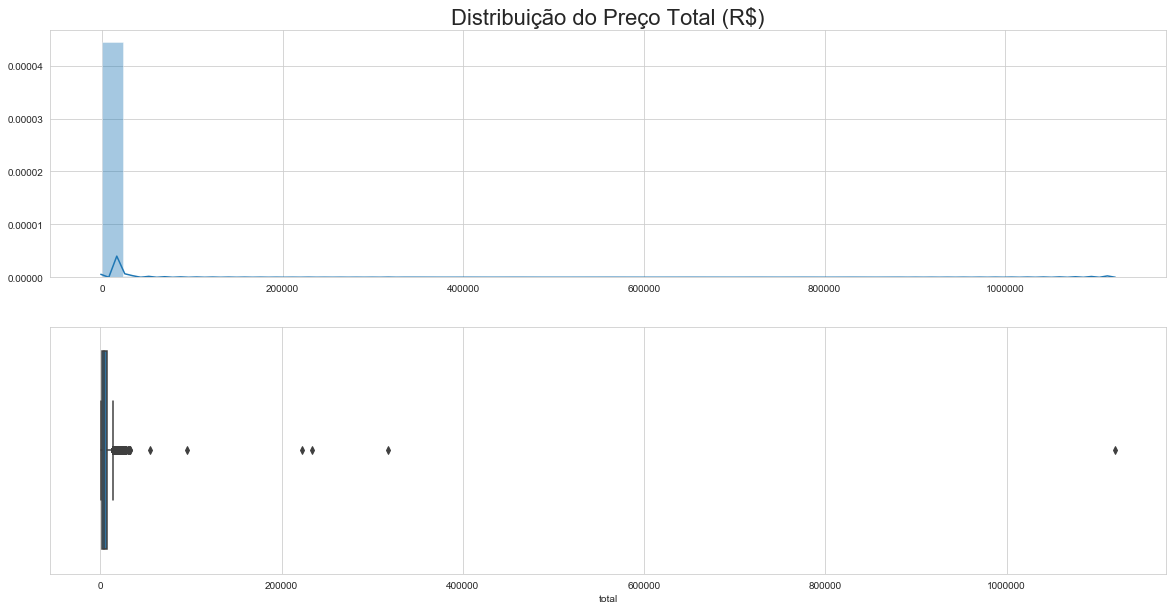

In [12]:
sns.set_style('whitegrid')

plt.figure(figsize =(20,10))
plt.subplot(2, 1, 1)
ax = sns.distplot(data['total'],kde =True)
ax.set_title('Distribuição do Preço Total (R$)',fontsize=22)
ax.set_xlabel('')

plt.subplot(2, 1, 2)
sns.boxplot(data['total'])

ax = ax

> Visualizando o segundo gráfico (Boxplot) é possível perceber a presença de alguns outliers no conjunto que seram retirados para não prejudicar na construção do modelo.

---


## Removendo o Outlier

In [13]:
outliers = data.query('total > 40000')
data = data.drop(index = outliers.index)


### Gráfico da distribuição do Preço Total (Sem outlier)

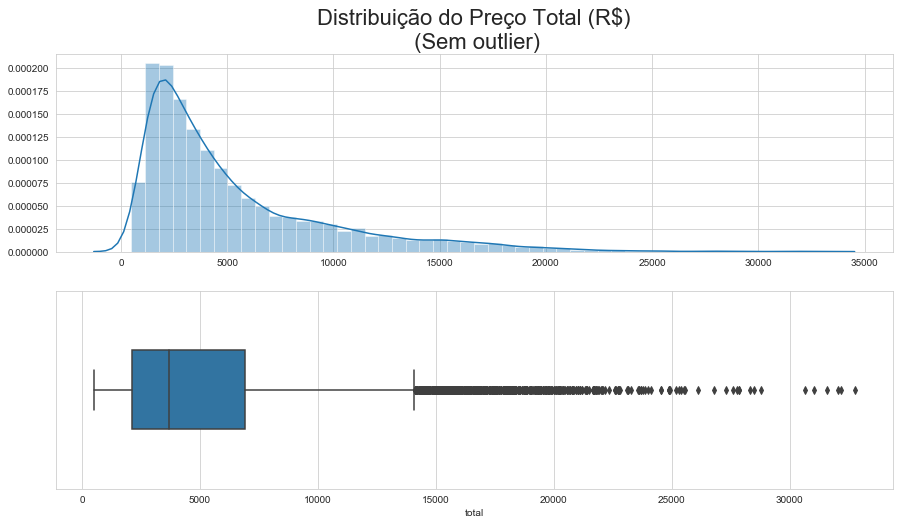

In [14]:
plt.figure(figsize =(15,8))
plt.subplot(2, 1, 1)
ax = sns.distplot(data['total'],kde =True)
ax.set_title('Distribuição do Preço Total (R$)\n (Sem outlier)',fontsize=22)
ax.set_xlabel('')

plt.subplot(2, 1, 2)
sns.boxplot(data['total'], width = .4)

ax = ax


In [15]:
data['total'].describe()

count    10328.000000
mean      5294.394074
std       4506.431461
min        499.000000
25%       2114.750000
50%       3683.500000
75%       6903.500000
max      32750.000000
Name: total, dtype: float64

> Agora sem os outliers é possível realizar uma melhor visualização dos dados. Podemos ver que o gráfico ainda tem o comportamento inclinado a esquerda. A seguir o comportamento dos dados:

- Média: 5294

    - Média Aritmética - A média de um conjunto de valores numéricos é calculada somando-se todos estes valores e dividindo-se o resultado pelo número de elementos somados, que é igual ao número de elementos do conjunto, ou seja, a média de n números é sua soma dividida por n.
$$M_s = \dfrac{x_1 + x_2 + ... + x_n}{n} $$

- Mediana: 3683

    - Mediana - A Mediana (Md) representa o valor central de um conjunto de dados. Para encontrar o valor da mediana é necessário colocar os valores em ordem crescente ou decrescente.

- Máximo: 32750
    - Máximo - O máximo é o valor máximo do que o dado alcança.
    
- Minimo: 499

    - Minimo - O Minimo é o valor Minimo do que o dado alcança.

---

## Gráfico da distribuição do Valor de Aluguel

---


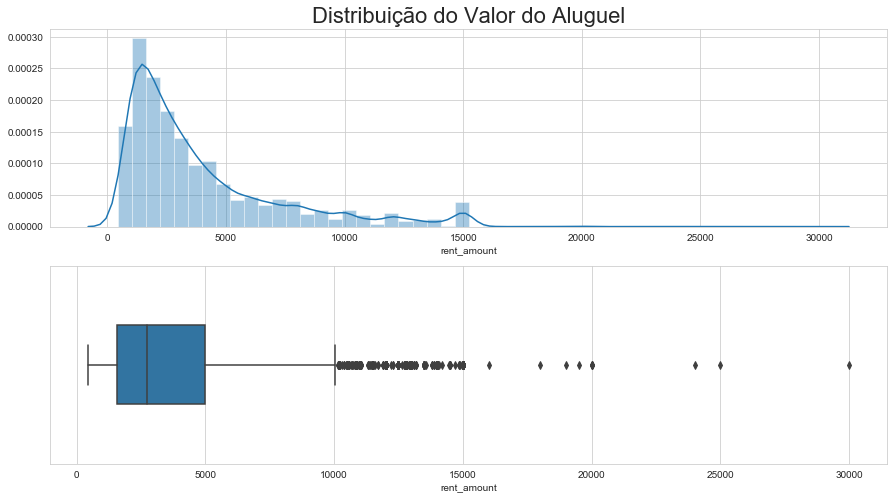

In [16]:
plt.figure(figsize =(15,8))
plt.subplot(2, 1, 1)
ax = sns.distplot(data['rent_amount'],kde =True)
ax.set_title('Distribuição do Valor do Aluguel',fontsize=22)


plt.subplot(2, 1, 2)
sns.boxplot(data['rent_amount'],width=.4)

ax = ax

In [17]:
data['rent_amount'].describe()

count    10328.000000
mean      3960.196844
std       3408.763176
min        450.000000
25%       1590.000000
50%       2750.000000
75%       5000.000000
max      30000.000000
Name: rent_amount, dtype: float64

> Podemos ver que o gráfico tem um corpotamento inclinado a esquerda, tendo seu valor máximo em RS10800 e minimo em RS450. Sendo que a maioria dos dados esta contida no intervalo de 450 e 4000. A seguir o comportamento dos dados.


- Média: 3960

- Mediana: 2750

- Máximo: 30000

- Minimo: 450

---

## Relação entre o Número de  quartos e o Preço total

---

 
A correlacão entre o preço total e o número de quartos é = [0.545]



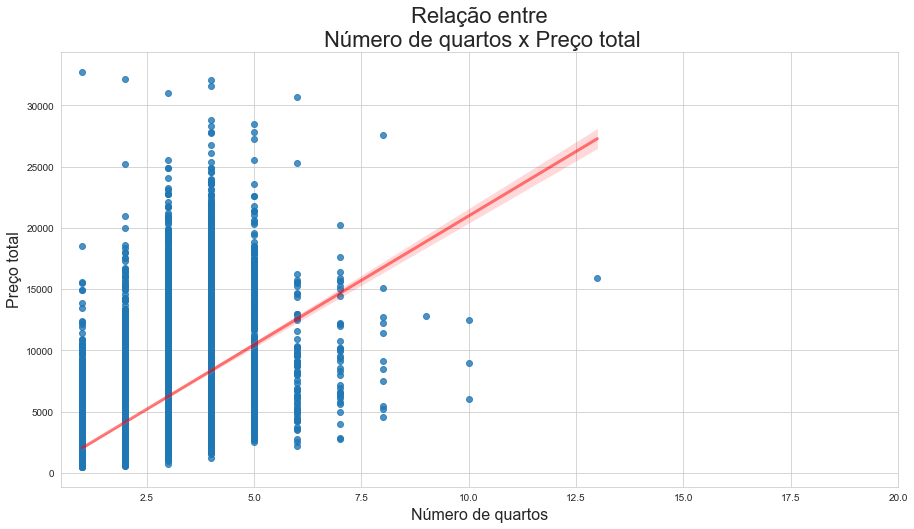

In [18]:

ax = sns.regplot(y= data['total'],x = data['rooms'],line_kws={'lw':3,'color':'r','alpha':0.5 })
ax.figure.set_size_inches(15,8)
ax.set_xlim(0.5, 20)
ax.set_title('Relação entre\n Número de quartos x Preço total',fontsize=22)
ax.set_xlabel('Número de quartos',fontsize=16)
ax.set_ylabel('Preço total',fontsize=16)


corr = data.corr()
corr_total = corr['total']
print(' ')
print('A correlacão entre o preço total e o número de quartos é =',[corr_total.loc['rooms'].round(3)])
print('')

> Ao analisar o gráfico e ver que existe uma relação considerável entre o preço do aluguel e o número de quartos dos imóveis, quanto maior o número de quartos maior o valor do aluguel. Os imóveis que alcançaram os maiores valores tinham um total de 4 quartos.

---

## Relação entre a Aceitação de animais e o Preço total

---

In [19]:
to_map_animal2 = {'acept':'Aceita',
         'not acept':'Não aceita'}

data['animal'] = data['animal'].map(to_map_animal2)


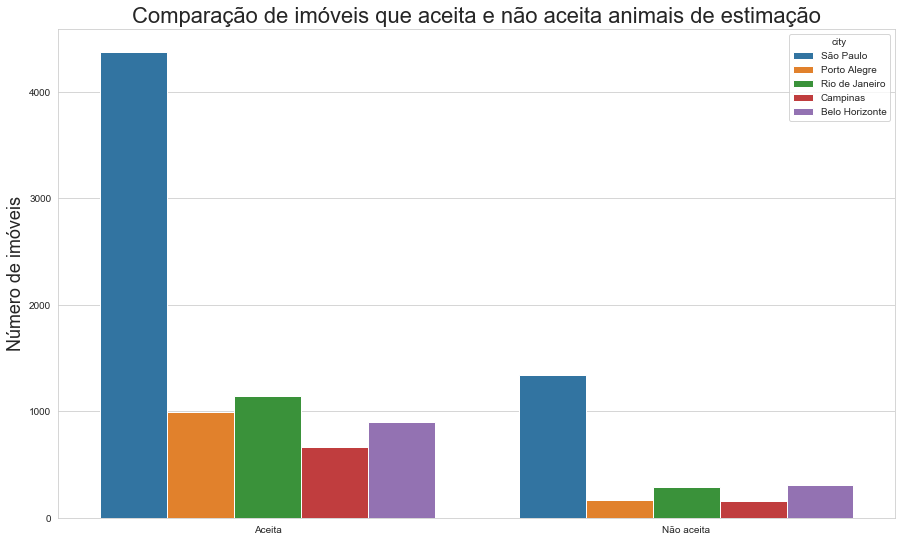

In [20]:
ax = sns.countplot(data['animal'],hue = data['city'])
ax.figure.set_size_inches(15,9)
ax.set_ylabel('Número de imóveis',fontsize=18)
ax.set_xlabel('',fontsize=18)
ax.set_title('Comparação de imóveis que aceita e não aceita animais de estimação',fontsize=22)

ax = ax

> Podemos ver que a maioria dos imóveis aceitam animais, tendo uma relação de aproximadamente 70/30, sendo assim nossos dados estão desbalanceados. São Paulo é a cidade que tem a maior aceitação de animais. 

---

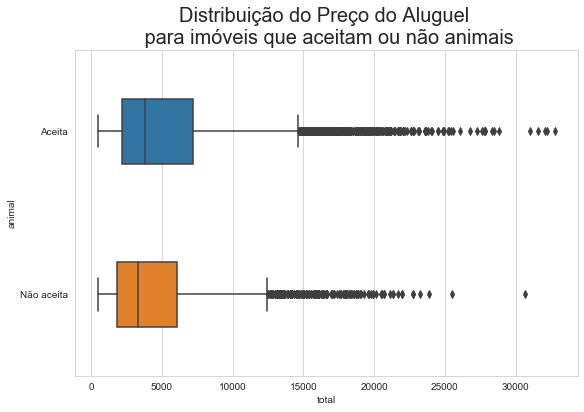

In [21]:
ax = sns.boxplot(data= data, x= 'total',y ='animal',width=0.4)
ax.figure.set_size_inches(9,6)
ax.set_title('Distribuição do Preço do Aluguel \n para imóveis que aceitam ou não animais',fontsize=20)

ax = ax

> A maioria dos imóveis que permitem animais tem um preço total maior comparado aos imóveis que não permitem animais.
---


## O apartamento estar mobiliado tem algum impacto no preço do aluguel?

In [22]:
to_map_furniture2 = {'furnished':'Mobiliada',
                     'not furnished':'Não mobiliada'}

data['furniture'] = data['furniture'].map(to_map_furniture2)


Existem 2513 imóveis mobiliados e 7815 não mobiliados


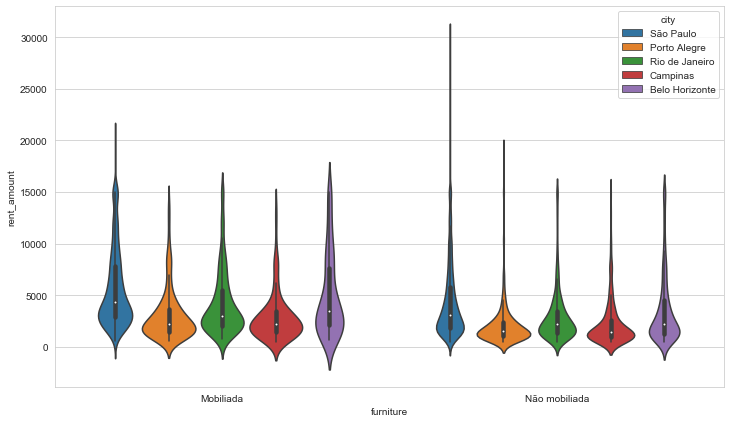

In [23]:
total = len(data['furniture_binary'])
mobiliados = data['furniture_binary'].sum()
nao_mobiliados = total - mobiliados

print('Existem {} imóveis mobiliados e {} não mobiliados'.format(mobiliados, nao_mobiliados))



sns.violinplot(x ='furniture', y ='rent_amount', data = data,hue ='city').figure.set_size_inches(12,7)


> Com o auxílio do gráfico e dos dados é possível concluir que não há muita difrença no preço total se o imóvel é mobiliado ou não para todas as cidades, podemos ver também que existem mais imóvies não mobiliados, do que mobiliados.

----

## Relação entre o IPTU e o Preço total do aluguel

---

Correlação entre Valor do IPTU x Preço total - 0.651


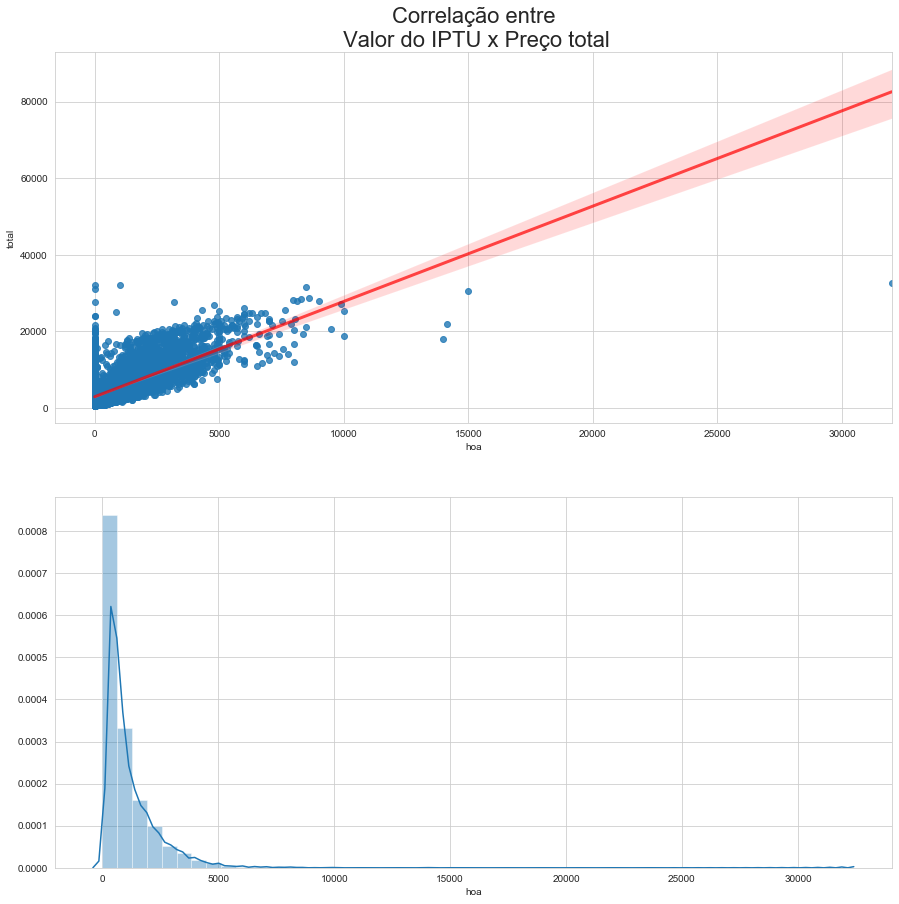

In [24]:
plt.figure(figsize =(15,15))

#########################
plt.subplot(2,1,1)
ax = sns.regplot(data['hoa'],data['total'],line_kws={'lw':3,'color':'r','alpha':0.7})
ax.set_title('Correlação entre\n Valor do IPTU x Preço total', fontsize=22)


#########################
plt.subplot(2,1,2)
sns.distplot(data['hoa'],kde =True)


print("Correlação entre Valor do IPTU x Preço total -",corr_total.loc['hoa'].round(3) )

> Podemos ver que o valor do IPTU tem uma correlação relevante e positiva, quanto maior o preço do IPTU maior o preço total do aluguel.

---

## Relação entre Vagas para estacionamento e o Preço do aluguel.

---

Correlação entre Número de vagas para estacionamento x Preço total - 0.584


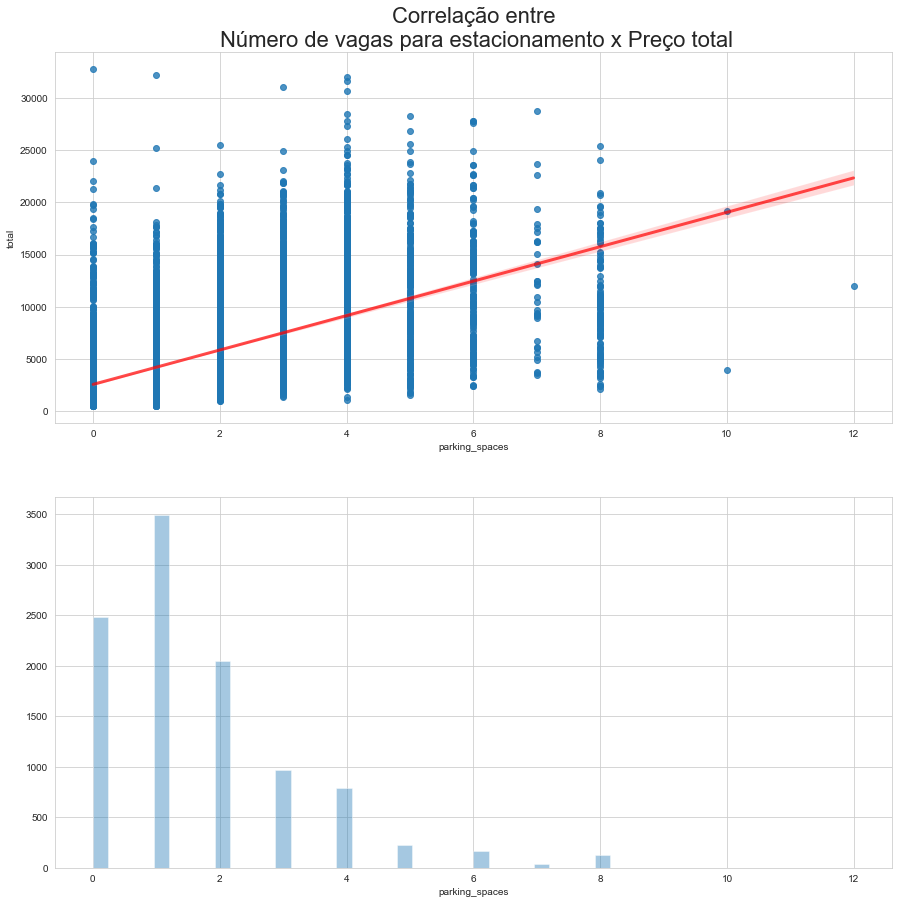

In [25]:
plt.figure(figsize =(15,15))

#########################
plt.subplot(2,1,1)
ax = sns.regplot(data['parking_spaces'],data['total'],line_kws={'lw':3,'color':'r','alpha':0.7})
ax.set_title('Correlação entre\n Número de vagas para estacionamento x Preço total', fontsize=22)


#########################
plt.subplot(2,1,2)
sns.distplot(data['parking_spaces'],kde =False)


print("Correlação entre Número de vagas para estacionamento x Preço total -",corr_total.loc['parking_spaces'].round(3) )

> Podemos ver que a correlação entre o número de vagas de estacionamento e o preço total é positiva, quanto mais vagas para estacionamento maior o preço do aluguel total.

---

## Relação entre Seguro contra incêndio e o Preço do aluguel.

---

Correlação entre Seguro contra incêndio x Preço total - 0.922


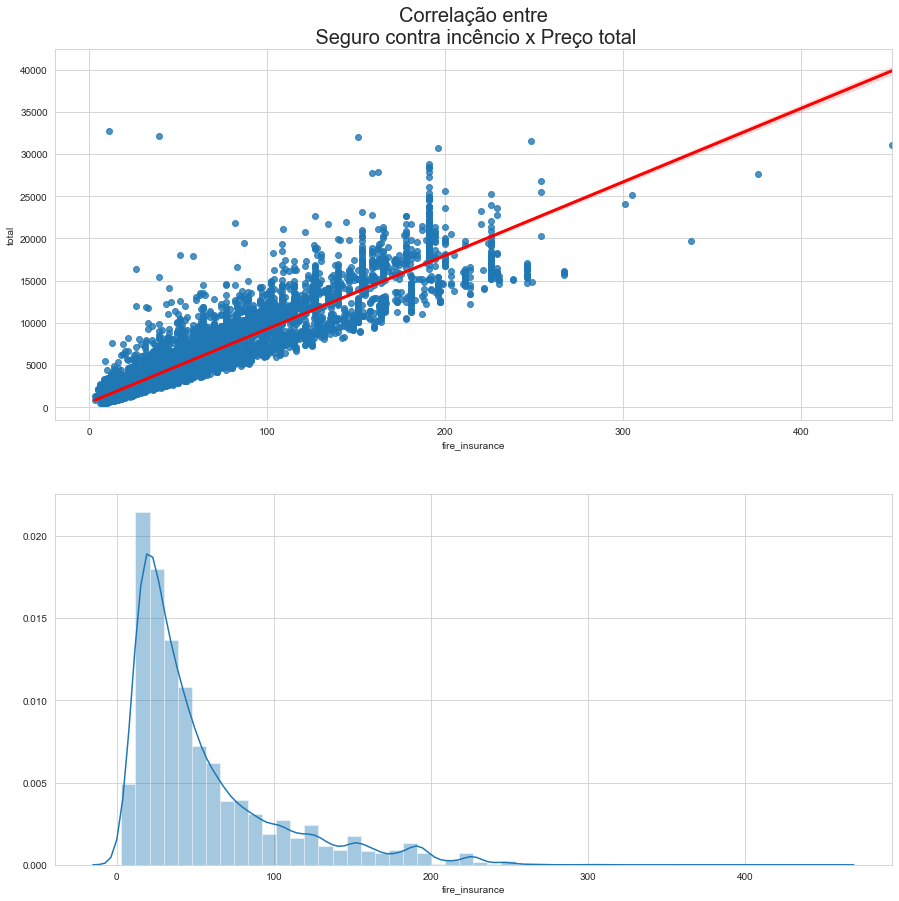

In [26]:
plt.figure(figsize =(15,15))

#########################
plt.subplot(2,1,1)
ax = sns.regplot(data['fire_insurance'],data['total'],line_kws={'lw':3,'color':'r'})
ax.set_title('Correlação entre\n Seguro contra incêncio x Preço total', fontsize=20)

#########################
plt.subplot(2,1,2)
sns.distplot(data['fire_insurance'],kde =True)

print("Correlação entre Seguro contra incêndio x Preço total -",corr_total.loc['fire_insurance'].round(3) )

> Podemos ver que também existe uma correlação forte e positiva entre seguro contra incêncio e o preço total.

----

## Relação entre a Área e o Preço total. 

---

Correlação entre Area x Preço total - 0.186


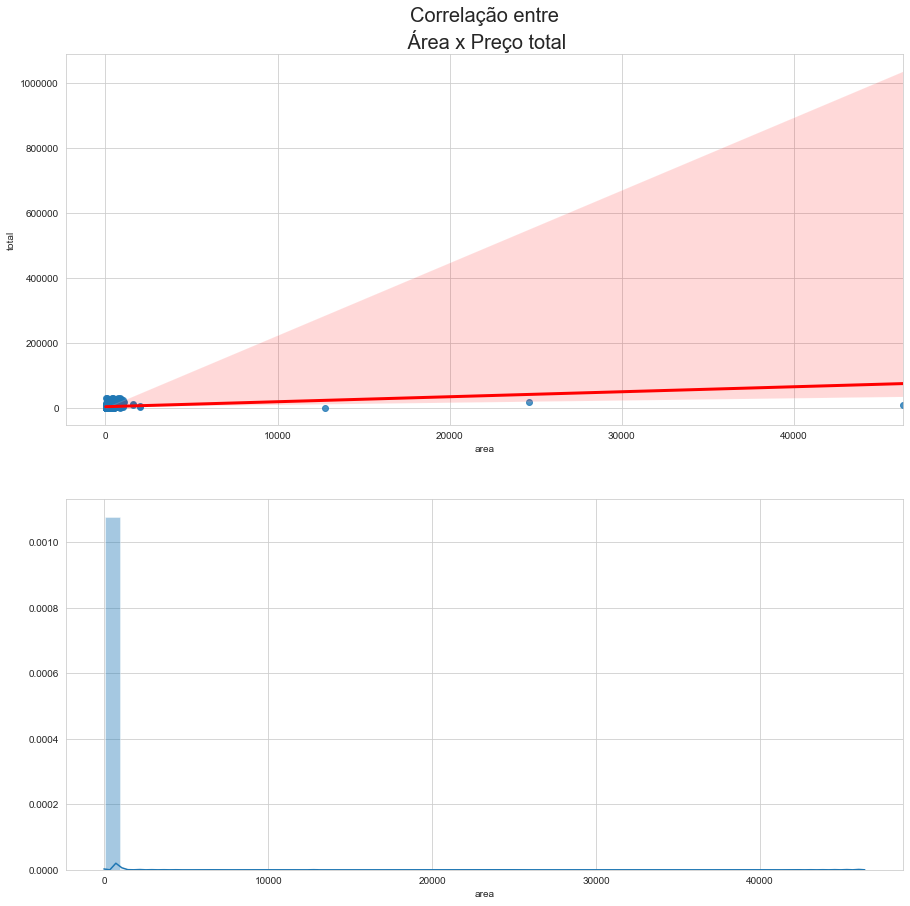

In [27]:
plt.figure(figsize =(15,15))

#########################
plt.subplot(2,1,1)
ax = sns.regplot(data['area'],data['total'],line_kws={'lw':3,'color':'r'})
ax.set_title('Correlação entre\n Área x Preço total', fontsize=20)

#########################
plt.subplot(2,1,2)
sns.distplot(data['area'],kde =True)

print("Correlação entre Area x Preço total -",corr_total.loc['area'].round(3) )

> A correlação entre a Área e o preço total a se pagar é muito fraca, parece não ter relação entre a área do imóvel e o preço do aluguel.

----

## Melhores Variáveis para o Modelo

---

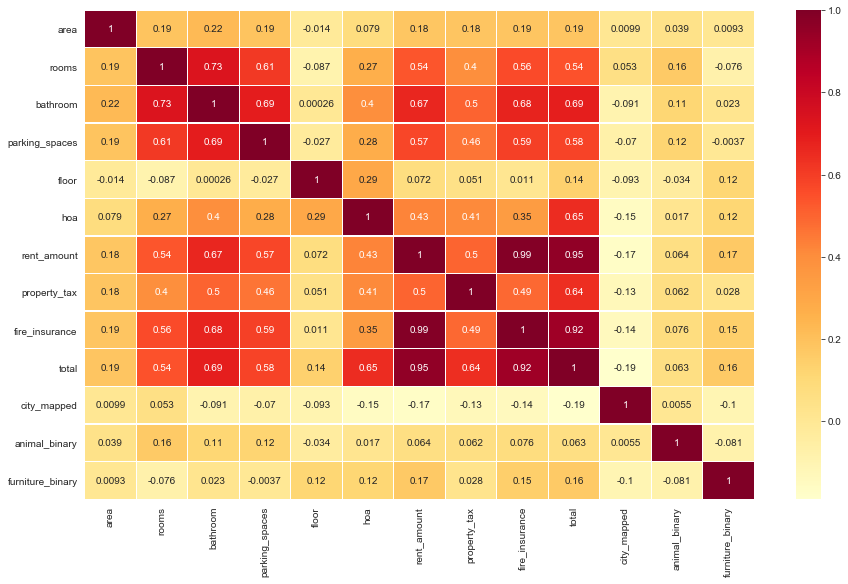

In [28]:
ax = sns.heatmap(corr, annot = True, linewidths = 0.4, cmap = "YlOrRd")
ax.figure.set_size_inches(15,9)

> Com o auxílio do heatmap e da análise já realizada podemos escolher as seguintes features para o nosso modelo 

- Rooms (Quartos)

- Parking Spaces (Vagas na Garagem)

- HOA (Valor de Condominio)

- Property Tax (IPTU)

- Fire Insurance (Seguro Contra Incêndio)

- City (Cidade)

> *Não foram escolhidas 'Bathroom' e 'Rent Amout', pois Bathroom não teria significância no modelo. Rent Amount não foi escolhido pois não vejo sentido em tentar prever o preço total do aluguel de um imóvel utilizando o preço do aluguel.*

## Modelo Preditivo

### Separando os dados em dados de treino e dados de teste

In [29]:
x = data[['rooms','parking_spaces','hoa','property_tax','fire_insurance','city_mapped']]

y = data['total']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=25)


In [30]:
x_train_cte = sm.add_constant(x_train)

### Sumário do Modelo

In [31]:
model_sm = sm.OLS(y_train, x_train_cte, hasconst = True).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.301e+05
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        00:59:49   Log-Likelihood:                -54199.
No. Observations:                7229   AIC:                         1.084e+05
Df Residuals:                    7222   BIC:                         1.085e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            255.5229     14.547     17.

### Números importantes

Antes de treinar nosso modelo temos que ver se as variáveis usadas para o modelo são boas, para saber isso tem alguns indicadores.

- R² (R-squared) - R² é o coeficiente de determinação do modelo, este número vária de 0 a 1. Quanto maior o R², mais explicativo é o modelo é, ou seja, melhor ele se ajusta à amostra. Por exemplo, um R² = 0,992 significa que o modelo linear explica 99,20% do valor do aluguel total.

- R² Ajustado (Adj R-squared) - É uma medida alternativa ao R², que penaliza a inclusão de variáveis pouco explicativas, ou seja, que tem uma relevância baixa para o modelo.

- p > |t| (p-value) -  Para o p-valor rejeita-se valores acima de 0,05 (5%). Em termos gerais, um p-value pequeno significa que a probabilidade de obter um valor da estatística de teste como o observado é muito improvável, levando assim à rejeição da hipótese nula.

- prob(F-statistic) - O valor de Prob(F) é a probabilidade de que a hipótese nula para o modelo completo seja verdadeira .   Por exemplo, se o Prob(F) tiver um valor de 0,05, haverá 5 chance em 100 de que todos os parâmetros de regressão sejam zero.

|Variável|Valor|
|-------|:----:|
|R²|0.992 |
|Adj R²|0.992 |
|p-value|0.00*|
|prob(F)|0.00 |

*Para todas as variáveis os valores de p-value são os mesmos.


## Pipeline
### Modelos utlizados 

- #### Linear Regression
    > O modelo de Regressão Linear ajustará a reta que melhor explique o valor da variável dependente (y), no caso do nosso projeto y seria o valor do aluguel, utilizando os valores das variáveis preditoras (X), que seria o número de quartos, vagas na garagem... 
    
    >Para um problema de Regressão Linear caso seja fornecido apenas um valor de X, a regressão linear é do tipo simples, caso seja fornecido dois ou mais a regressão é do tipo mútltipla.
    
    - *O gráfico de uma regressão simples é dado por:*
    
    ![title](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/400px-Linear_regression.svg.png)
    
    > A equação da Regressão Linear Simples é dada por:
    
    $$y_i = \beta_0 + \beta_1 X_i + \epsilon_i $$
    
    - $y_i$ o valor da variável na i-ésima observação;
    - $\beta_0$ e $\beta_1$ os parâmetros;
    - $X_i$ é o valor da variável preditora;
    - $\epsilon_i$ é o termo relacionado ao erro.
    
    > Já a equação da Regressão Linear Múltipla é dada por:
    
    $$y_i = \beta_0 + \beta_1 X_{1} + \beta_2 X_{2} + ... + \beta_n X_{n} + \epsilon$$
    
    - $y_i$ o valor da variável na i-ésima observação;
    - $\beta_0$ e $\beta_1$ os parâmetros;
    - $X_i,...,X_n$ são os valor da variável preditora;
    - $\epsilon_i$ é o termo relacionado ao erro.

---
    
- #### Ridge
    > O modelo de Ridge Regression aborda alguns problemas dos mínimos quadrados ordinários impondo uma penalidade no tamanho dos coeficientes. Os coeficientes de ridge minimizam a soma residula penalizada de quadrados:
    
    $$\min_w = || Xw - y ||_2^2 + \alpha||w||_2^2$$
    
    > O parâmetro de complexidade $\alpha \geq 0$ controla a quantidade de encolhimento: quanto maior o valor de $\alpha$, maior a quantidade de encolhimento e, portanto, os coeficientes se tornam mais robustos à colinearidade.
        
- #### Lasso
    > Em Machine Learning, a Regressão Lasso é um método de análise de regressão que executa a seleção de variáveis e a regularização , a fim de melhorar a precisão das previsões e a interpretabilidade do modelo estatístico que produz. 
    
    > A Regressão Lasso foi originalmente formulado para modelos de regressão linear e este caso simples revela uma quantidade substancial sobre o comportamento do estimador, incluindo sua relação com a Regressão de Ridge e a melhor seleção de subconjuntos e as conexões entre estimativas do coeficiente de Lasso e o chamado limiar suave. Também revela que (como a regressão linear padrão) as estimativas do coeficiente não precisam ser únicas se as covariáveis forem colineares .
    
- #### DecisionTreeRegressor
    > O modelo de Decision Tree Regressor ou Árvore de Decisão é uma ferramenta de suporte à toma de decisão que usa um gráfico no formato de árvore e pode demonstrar visualmente as condições e as probabilidades para se chegar aos resultados. O algoritmo é do tipo aprendizado supervisionado.
    
    > Uma Árvore de Decisão chega a um valor estimado fazendo uma série de perguntas aos dados, cada uma restringindo os possíveis valores até que o modelo fique confiante o suficiente para realizar uma previsão. A ordem das perguntas a serem feitas assim como o conteúdo são determinados pelo modelo. Além disso todas as perguntas tem o formato de resposta True ou False (Verdadeiro ou Falso).
    
    > Para cada resposta True ou False existem ramos separados da árvore. Independentemente das respostas das perguntas feitas pelo modelo sempre chegamos a uma previsão. O modelo de Decision Tree Regressor aprende a mapear os dados para o output (saída) na fase de treinamento do modelo, sendo assim o modelo aprende qualquer relacionamento entre os dados e a variável de destino.
    
   > Após a fase de treinamento, a árvore de decisão produz uma árvore semelhante a mostrada a seguir, onde é calculada as melhores perguntas e sua ordem de ser realizadas a fim de tornar as estimativas mais precisas. Quando queremos fazer uma previsão, o mesmo formato de dados deve ser fornecido ao modelo para fazer uma previsão.  A previsão será uma estimativa com base nos dados de treino.
    
    ![title](./img/arvore.png)
    *Está árvore de decisões não representa a árvore do projeto*
    
---  
- #### RandomForestRegressor
    > O modelo de Random Forest Regression é um algoritmo de aprendizado fléxivel e fácil de ser utilizado, que pode produzir bons resultados. É um algoritmo muito utilizado pois pode ser utilizado tanto para problemas de regressão e classificação. 
    
    > O algoritmo é do tipo de aprendizado supervisionado. O modelo cria um 'floresta', que seria uma combinação de árvores de decisões, na maioria dos casos treinados com o método *bagging*. A idéia principal do método de *bagging* é que a combinação dos modelos de aprendizado aumenta o resultado geral.
    
    > Resumidamente o algoritmo Random Forest cria várias árvores de decisão e as combina para obter uma predição com maior ácuracia e mais estável.
    
    ![](./img/floresta.png)
    
    ---

In [32]:
accuracy = []
model = {'Linear Regression':LinearRegression(),
         'Lasso': Lasso(),
         'Ridge':Ridge(),
         'DecisionTreeRegressor': DecisionTreeRegressor(),
         'RandomForestRegressor': RandomForestRegressor()}

for i in model:
    model[i].fit(x_train, y_train)
    
    accuracy.append([i, r2_score(y_test, model[i].predict(x_test))])

accuracy.sort(key = lambda y:y[1],reverse =True)

accuracy

[['Lasso', 0.9905163739585988],
 ['Linear Regression', 0.9905160300872593],
 ['Ridge', 0.9905160273442086],
 ['RandomForestRegressor', 0.9858554324691177],
 ['DecisionTreeRegressor', 0.9797451970434039]]

> Como Lasso foi o que obteve a melhor acuracia é o que vai ser utilizado para treinar nosso modelo final.

---

## Treinando o modelo final

In [33]:
model = Lasso()
model.fit(x_train,y_train)
print('R² -', r2_score(y_test,model.predict(x_test)))

import pickle
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

R² -  0.9905163739585988


## Comparação entre o Valor Real e o Valor Previsto

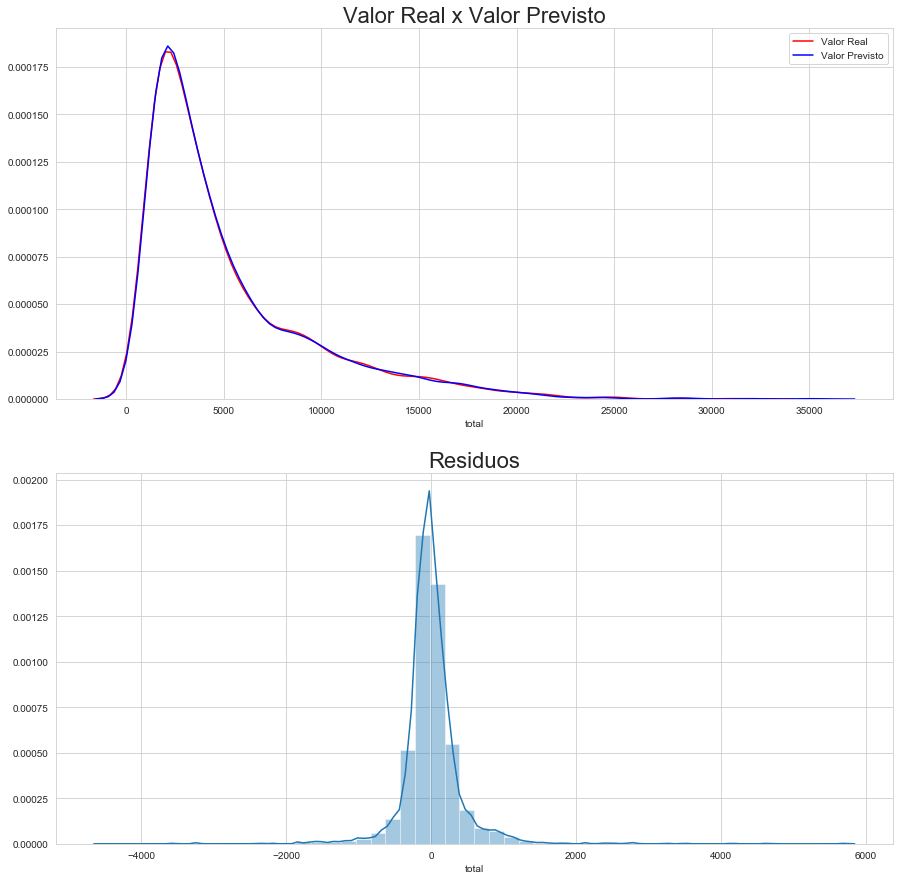

In [34]:
plt.figure(figsize =(15,15))

#########################
plt.subplot(2,1,1)

ax1 = sns.distplot(y_test,hist=False,kde =True,color ="red",label ="Valor Real")
sns.distplot(model.predict(x_test),color ="blue",hist = False,kde =True, label = "Valor Previsto",ax =ax1)

ax1.set_title('Valor Real x Valor Previsto',fontsize = 22)

#########################
plt.subplot(2,1,2)

residuos = y_test - model.predict(x_test)

ax = sns.distplot(residuos)
ax.set_title('Residuos',fontsize=22)

plt.show()

### Análise dos Gráficos

> Podemos ver utilizando o gráfico de Valores Reais x Valores Previstos que o modelo realiza previsões bem próximas a realidade. Os dados utilizados para realizar previsões não são os mesmos que foram utilizados para realizar o treinamento do modelo.

> Para verificar se o modelo está bem ajustado aos dados o gráfico dos resíduos tem que ter a forma normal, dispersos em torno de zero. Em nosso gráfico de resíduos podemos ver um comportamento de normalidade, significando um bom ajuste do modelo aos dados.